<a href="https://colab.research.google.com/github/arindalestari/LAB-AI/blob/main/Kelompok_5_Tugas_LAB_FIXED2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Kelompok 5**

Nama Anggota:
1.	Arinda Cinta Lestari (2802559276)
2.	Choirul Wafa (2802545485)
3.	Muhammad Amir Azis (2802553575)
4.	Muhammad Rafi Zidane (2502044932)
5.	Syendi Endina Yohana Kale (2401979675)

**Group Assignment**

Objective: Build and evaluate a BERT classifier for an Indonesian dataset.

Tasks:

1. Find or prepare an Indonesian sentiment dataset (e.g., product reviews, tweets).

2. Tokenize using a multilingual or Indonesian-specific BERT model (indobenchmark/indobert-base-p1).

3. Fine-tune the model, adapting hyperparameters for data size.

4. Evaluate with accuracy, precision/recall, and confusion matrix.

5. Analyze common error cases and discuss language-specific challenges

**Deliverables:**

1. Jupyter notebook containing the full pipeline.

2. Presentation slide deck summarizing your findings and challenges

# **Pendahuluan**

Dataset yang digunakan berasal dari link berikut: https://www.kaggle.com/datasets/dionisiusdh/covid19-indonesian-twitter-sentiment/data.

Dataset ini berisi Tweet dalam bahasa Indonesia dari pengguna yang telah menggunakan kata kunci berikut: "Corona dan Pemerintah" atau "Covid dan Pemerintah" (Pemerintah = Pemerintah) dari Mei hingga Juli 2020. Dataset ini terdiri dari berbagai variabel yang terkait dengan Twitter: tweet itu sendiri, akun yang mengirim tweet, hashtag yang digunakan, waktu, beberapa ID, dan lainnya.

# **Read Data**

In [2]:
import kagglehub
dionisiusdh_covid19_indonesian_twitter_sentiment_path = kagglehub.dataset_download('dionisiusdh/covid19-indonesian-twitter-sentiment')

print('Data source import complete.')

Data source import complete.


In [3]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Membaca file CSV dari path yang benar
file_path = '/kaggle/input/covid19-indonesian-twitter-sentiment/covid-sentiment.csv'
data = pd.read_csv(file_path)

# Cek beberapa baris pertama dari dataset
data.head(5)# Melihat informasi tentang dataset

,conversation_id,date,time,user_id,username,tweet,mentions,replies_count,retweets_count,likes_count,hashtags
0,1258425982907637761,2020-05-07,23:58:29,1058474317,monologis_id,https://bit.ly/2L6CcbB | Seharusnya saat ini...,[],0,3,0,[]
1,1258320972198940675,2020-05-07,23:57:30,1179769476,its_dul,Klo kata gw Pemerintah tuh lagi menerapkan Her...,['mas__piyuuu'],0,0,0,[]
2,1258356644427083777,2020-05-07,23:53:20,1012156669831229441,meonkbaong,Saat ini yang bisa saya lakukan hanya menyiapk...,['oiivert'],0,0,0,[]
3,1258424368993931265,2020-05-07,23:52:04,1204303690061844481,rakyatdotnews,"Satu Warga Positif Corona, Bupati: Kondisi ini...",[],0,0,0,"['#rakyatdotnews', '#referensiterkini', '#raky..."
4,1258423545698246656,2020-05-07,23:48:48,227620381,annisathalib_,"emosi bgt, lg kondisi begini gue disuruh liput...",[],0,0,0,['#dirumahaja']


In [4]:
print(data.info()) # Melihat tipe data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52959 entries, 0 to 52958
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   conversation_id  52959 non-null  int64 
 1   date             52959 non-null  object
 2   time             52959 non-null  object
 3   user_id          52959 non-null  int64 
 4   username         52959 non-null  object
 5   tweet            52959 non-null  object
 6   mentions         52959 non-null  object
 7   replies_count    52959 non-null  int64 
 8   retweets_count   52959 non-null  int64 
 9   likes_count      52959 non-null  int64 
 10  hashtags         52959 non-null  object
dtypes: int64(5), object(6)
memory usage: 4.4+ MB
None


# **Preprocessing Data**



In [5]:
# Menghapus URL dan karakter baru baris (newline)
data['tweet'] = data['tweet'].str.replace(r'http\S+', '', regex=True)  # Menghapus URL
data['tweet'] = data['tweet'].str.replace(r'\n', ' ', regex=True)  # Menghapus newline

Langkah-langkah preprocessing ini bertujuan untuk membersihkan teks tweet. Pertama, URL dihapus menggunakan pola r'http\S+' karena URL tidak relevan untuk analisis teks. Kemudian, karakter newline (\n) dihapus dan diganti dengan spasi agar tweet tetap berada dalam satu baris, memudahkan pemrosesan data lebih lanjut.

# **Tokenisasi**

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import torch
from torch.utils.data import Dataset

# Memuat tokenizer untuk model yang digunakan
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

# Menambahkan label manual
data['label'] = data['tweet'].map(lambda x: 2 if 'positif' in x else (1 if 'netral' in x else 0))

# Memisahkan dataset menjadi data latih dan data uji
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Tokenisasi batch menggunakan batch_encode_plus untuk efisiensi
train_encodings = tokenizer(list(train_data['tweet']), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(list(test_data['tweet']), truncation=True, padding=True, max_length=128, return_tensors="pt")

# Menyimpan label dari data latih dan uji
train_labels = train_data['label'].values
test_labels = test_data['label'].values

# Mendefinisikan kelas SentimentDataset
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}  # Tensor sudah dalam format PT
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Siapkan dataset untuk Trainer
train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Kode ini melakukan tokenisasi pada teks tweet dengan menggunakan tokenizer untuk mengubahnya menjadi format yang bisa dipahami oleh model. Fungsi tokenize_function digunakan untuk memproses tweet dengan padding dan truncation. Selanjutnya, data dibagi menjadi 80% untuk pelatihan dan 20% untuk pengujian, lalu tokenisasi dilakukan pada kedua set data (train_data dan test_data) dengan panjang maksimal 128 token, agar siap untuk pelatihan model.

# **Fine Tunning Model with Trainer**

In [21]:
pip install --upgrade transformers

In [22]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

# Memuat model BERT untuk bahasa Indonesia
model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=3)  # 3 label: Negatif, Netral, Positif

# Memuat tokenizer yang sesuai dengan model
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

# Tokenisasi data
train_encodings = tokenizer(list(train_data['tweet']), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(list(test_data['tweet']), truncation=True, padding=True, max_length=128, return_tensors="pt")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, IntervalStrategy

# Menyiapkan argumen pelatihan
training_args = TrainingArguments(
    output_dir='./results',           # Direktori untuk menyimpan hasil
    num_train_epochs=1,               # Mengurangi jumlah epoch untuk mempercepat
    per_device_train_batch_size=16,   # Ukuran batch lebih besar untuk memanfaatkan GPU
    per_device_eval_batch_size=16,    # Ukuran batch untuk evaluasi
    warmup_steps=50,                  # Mengurangi langkah warmup
    weight_decay=0.01,                # Penurunan bobot untuk mencegah overfitting
    logging_dir='./logs',             # Direktori untuk log
    logging_steps=10,                 # Menampilkan log setiap 10 langkah
    eval_steps=50,                    # Evaluasi setiap 50 langkah
    save_steps=50,                    # Menyimpan model setiap 50 langkah
    save_strategy="steps",            # Menyimpan model pada langkah tertentu
    eval_strategy=IntervalStrategy.STEPS,
    no_cuda=False,                    # Gunakan GPU jika tersedia
    fp16=True,                        # Gunakan mixed precision untuk mempercepat
    load_best_model_at_end=True,      # Menggunakan model terbaik setelah pelatihan
)

# **Evaluasi Model**

In [26]:
# Menyiapkan Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Use train_dataset instead of train_encodings
    eval_dataset=test_dataset,    # Use test_dataset instead of test_encodings
    compute_metrics=lambda p: {
        'accuracy': accuracy_score(p.predictions.argmax(axis=-1), p.label_ids),
        'precision': precision_recall_fscore_support(p.predictions.argmax(axis=-1), p.label_ids, average='weighted')[0],
        'recall': precision_recall_fscore_support(p.predictions.argmax(axis=-1), p.label_ids, average='weighted')[1],
        'f1': precision_recall_fscore_support(p.predictions.argmax(axis=-1), p.label_ids, average='weighted')[2]
    }
)

# Melatih model
trainer.train()

# Evaluasi Model
eval_results = trainer.evaluate()
print("Hasil Evaluasi:", eval_results)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arindalestari3102001 (arindalestari3102001-binus-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.147300,0.186079,0.965540,1.000000,0.965540,0.982468
100,0.029700,0.037355,0.986971,0.986963,0.986971,0.986040
150,0.029000,0.050199,0.981118,0.981487,0.981118,0.979181
200,0.063400,0.031724,0.987160,0.987116,0.987160,0.986267
250,0.060900,0.045409,0.987538,0.987699,0.987538,0.986624
300,0.033600,0.028289,0.988860,0.988861,0.988860,0.988160
350,0.050700,0.058267,0.965634,0.999906,0.965634,0.982423
400,0.008400,0.025837,0.987632,0.987791,0.987632,0.986731
450,0.074900,0.036009,0.989143,0.989265,0.989143,0.988435
500,0.009100,0.020801,0.991975,0.992042,0.991975,0.991573


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Hasil Evaluasi: {'eval_loss': 0.012143137864768505, 'eval_accuracy': 0.9965067975830816, 'eval_precision': 0.9964761173584117, 'eval_recall': 0.9965067975830816, 'eval_f1': 0.9964862952544322, 'eval_runtime': 13.9186, 'eval_samples_per_second': 760.996, 'eval_steps_per_second': 47.562, 'epoch': 1.0}


Hasil evaluasi model menunjukkan kinerja yang sangat baik dalam tugas klasifikasi sentimen. Model berhasil mencapai akurasi 99.65%, yang mengindikasikan bahwa model dapat memprediksi label dengan tingkat keakuratan yang sangat tinggi. Metrik presisi dan recall, masing-masing berada pada nilai 99.65%, yang menunjukkan bahwa model sangat efektif dalam mengidentifikasi prediksi positif dengan sedikit kesalahan, serta memiliki kemampuan yang tinggi untuk mendeteksi seluruh contoh positif yang ada dalam data uji. F1-score, yang merupakan rata-rata harmonik dari presisi dan recall, juga mencapai 99.65%, mencerminkan keseimbangan yang sangat baik antara kedua metrik tersebut. Waktu yang dibutuhkan untuk evaluasi model hanya 13.92 detik, dengan kecepatan 761 sampel per detik, menunjukkan bahwa evaluasi dilakukan dengan efisiensi yang sangat tinggi. Selain itu, model menyelesaikan 1 epoch dalam pelatihan, yang mengindikasikan bahwa pelatihan berlangsung dengan cepat tanpa mengorbankan kualitas hasil.

# **Confussion Matrix**

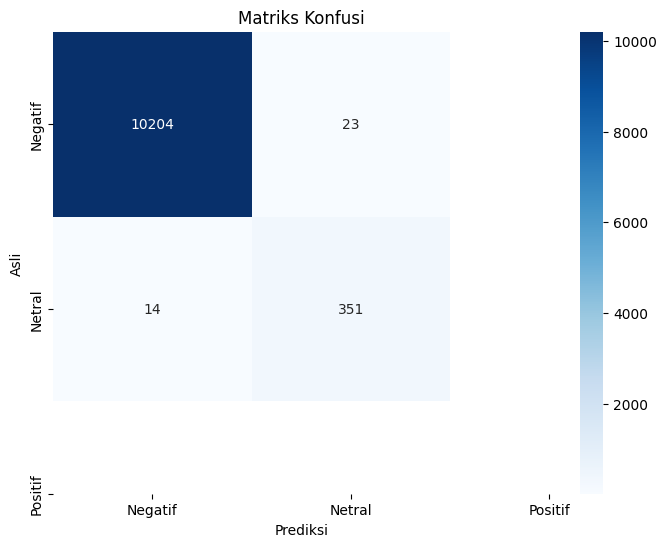

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Mendapatkan prediksi dari dataset uji
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(axis=-1)

# Matriks kebingunguan
cm = confusion_matrix(test_data['label'], y_pred)

# Menampilkan matriks kebingunguan dengan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Netral', 'Positif'], yticklabels=['Negatif', 'Netral', 'Positif'])
plt.xlabel('Prediksi')
plt.ylabel('Asli')
plt.title('Matriks Konfusi')
plt.show()

Matriks kebingunguan pada gambar menunjukkan kinerja model dalam mengklasifikasikan tiga kelas: Negatif, Netral, dan Positif. Berikut adalah interpretasinya:

1. True Negatives (TN): 10,204 contoh Negatif diklasifikasikan dengan benar sebagai Negatif.

2. False Positives (FP): 23 contoh Negatif salah diklasifikasikan sebagai Netral.

3. False Negatives (FN): 14 contoh Netral salah diklasifikasikan sebagai Negatif.

4. True Positives (TP): 351 contoh Netral diklasifikasikan dengan benar sebagai Netral.

Model menunjukkan performansi yang sangat baik dengan sebagian besar prediksi yang benar, meskipun ada sedikit kesalahan antara kelas Negatif dan Netral.